In [1]:
import pandas as pd
import datetime
from simulation_utils import SimulationConfig
import pm4py
import matplotlib.pyplot as plt
from O2C_process import O2C_Process

In [2]:
import datetime
from simulation_utils import SimulationConfig

# -----------------------------
# Simulation Horizon
# -----------------------------
LOG_PERIOD = 2 * 365 * 24 * 60 * 60  # 2 years in seconds
SIM_START = datetime.datetime(2025, 1, 1, 0, 0, 0, tzinfo=datetime.timezone.utc)

# -----------------------------
# Case and Event Parameters
# -----------------------------
MEAN_CASE_DURATION = 14 * 24 * 60 * 60  # 14 days in seconds
relevant_events_per_case = 6.4

PRODUCTIVITY_FACTOR = 1.0  # fraction of time working
mean_event_workingtime = (MEAN_CASE_DURATION * PRODUCTIVITY_FACTOR) / relevant_events_per_case

# Number of cases roughly within horizon
no_cases = int(LOG_PERIOD / MEAN_CASE_DURATION)

# Arrival process parameters
OVERLAP_FACTOR = (14 * 24 * 60 * 60) / (12*60*60)
mean_inter_arrival_time = (MEAN_CASE_DURATION / PRODUCTIVITY_FACTOR) / OVERLAP_FACTOR

ARRIVAL_DISTRIBUTION = (
    "normal",
    {"mean": mean_inter_arrival_time, "std": mean_inter_arrival_time * 0.25}
)

ARRIVAL_MODULATION = {
    "type": "monthly",
    "amplitude": 0.6,
    "phase": 0.0,
    "constant": 1.0
}

EVENT_WORKTIME = (
    "normal",
    {"mean": mean_event_workingtime, "std": mean_event_workingtime * 0.5}
)

# -----------------------------
# Resource Capacities
# -----------------------------
CAPACITIES = {
    "erp": int(OVERLAP_FACTOR * 1),
    "warehouse": int(OVERLAP_FACTOR * 1),
    "sales": int(OVERLAP_FACTOR * 1),
}

# -----------------------------
# Simulation Phases
# -----------------------------
PHASES = {
    "Phase 1": (
        (0, LOG_PERIOD),
        {"check_stock": 0.7}
    ),
}

# -----------------------------
# Schedules
# -----------------------------


#daily_hours = [(datetime.time(9, 0), datetime.time(17, 0))]  # 9am–5pm
#weekly_days = [0, 1, 2, 3, 4]  # Monday–Friday
#monthly_days = list(range(2, 32)) # 2nd–31st
#yearly_days = [ (m, d) 
#               for m in range(1, 13) 
#               for d in range(1, 32)
#               if not ((m == 6))] # exclude June 15-30

RESOURCE_SCHEDULES = {
    "erp": {
        "daily": [],
        "weekly": [],
        "monthly": [],
        "yearly": [],
    },
    "warehouse": {
        "daily": [],
        "weekly": [],
        "monthly": [],
        "yearly": [],
    },
    "sales": {
        "daily": [],
        "weekly": [],
        "monthly": [],
        "yearly": [],
    },
}

ARRIVAL_SCHEDULES = {
    "arrivals": {
        "daily": [],
        "weekly": [],
        "monthly": [],
        "yearly": [],
    }
}

# -----------------------------
# Build Simulation Config
# -----------------------------
config = SimulationConfig(
    capacities=CAPACITIES,
    resource_schedules=RESOURCE_SCHEDULES,
    phases=PHASES,
    arrival_distribution=ARRIVAL_DISTRIBUTION,
    arrival_modulation=ARRIVAL_MODULATION,
    arrival_schedules=ARRIVAL_SCHEDULES,
    event_worktime=EVENT_WORKTIME,
    max_sim_seconds=LOG_PERIOD,
    max_n_cases=None,
    sim_start=SIM_START,

)

In [3]:
o2c = O2C_Process(config)
df = o2c.run()

In [4]:
# remove ramp-up and ramp-down phase of log
trim_frac = 0.0  # fraction of cases to remove from start and end (change as needed)

# compute case start and end timestamps
start_times = df.groupby("case:concept:name")["time:timestamp"].min()
end_times = df.groupby("case:concept:name")["time:timestamp"].max()

# sort and determine how many cases to trim
starts_sorted = start_times.sort_values()
ends_sorted = end_times.sort_values()
n_cases_total = len(starts_sorted)
n_trim = int(n_cases_total * trim_frac)

if n_trim <= 0:
    df_trimmed = df.copy()
    print(f"trim_frac={trim_frac} results in n_trim=0 (n_cases={n_cases_total}) -> no trimming performed")
else:
    # first and last cases to remove
    cases_to_remove_start = list(starts_sorted.index[:n_trim])
    cases_to_remove_end = list(ends_sorted.index[-n_trim:])
    cases_to_remove = set(cases_to_remove_start + cases_to_remove_end)

    # drop those cases from the dataframe
    df_trimmed = df[~df["case:concept:name"].isin(cases_to_remove)].copy()

    print(f"Removed {len(cases_to_remove)} cases ({n_trim} from start, {n_trim} from end).")
    print(f"Remaining cases: {df_trimmed['case:concept:name'].nunique()}, events: {len(df_trimmed)}")


trim_frac=0.0 results in n_trim=0 (n_cases=1824) -> no trimming performed


In [5]:
print(df_trimmed)
df_trimmed.to_csv("tmp.csv", index=False)

      case:concept:name                     concept:name  \
0             Case_0001          Purchase Order Received   
1             Case_0001         Check Stock Availability   
2             Case_0001  Retrieve Product from Warehouse   
21            Case_0001                    Confirm Order   
22            Case_0001             Get Shipping Address   
...                 ...                              ...   
19857         Case_1824                  Receive Payment   
19858         Case_1824             Get Shipping Address   
19861         Case_1824                     Ship Product   
19864         Case_1824                    Archive Order   
19865         Case_1824                  Order Fulfilled   

                 time:timestamp  
0     2025-01-01 00:00:00+00:00  
1     2025-01-01 00:00:01+00:00  
2     2025-01-01 05:12:06+00:00  
21    2025-01-06 11:30:09+00:00  
22    2025-01-06 11:30:09+00:00  
...                         ...  
19857 2027-01-12 16:57:52+00:00  
19858 2

In [6]:
from pm4py.objects.conversion.log import converter as log_converter
from pm4py.objects.log.exporter.xes import exporter as xes_exporter

# Convert the DataFrame to an EventLog
log = log_converter.apply(df_trimmed, variant=log_converter.Variants.TO_EVENT_LOG)

# Export to XES
xes_exporter.apply(log, "syn_1.xes")



/home/mavo/miniconda3/envs/py3.10/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
exporting log, completed traces :: 100%|██████████| 1824/1824 [00:00<00:00, 8474.89it/s]


In [7]:
from pm4py.objects.log.importer.xes import importer as xes_importer

#log = xes_importer.apply('../raw/syn/syn_12h_yearly.xes')
#df = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

# Analysis of resulting log

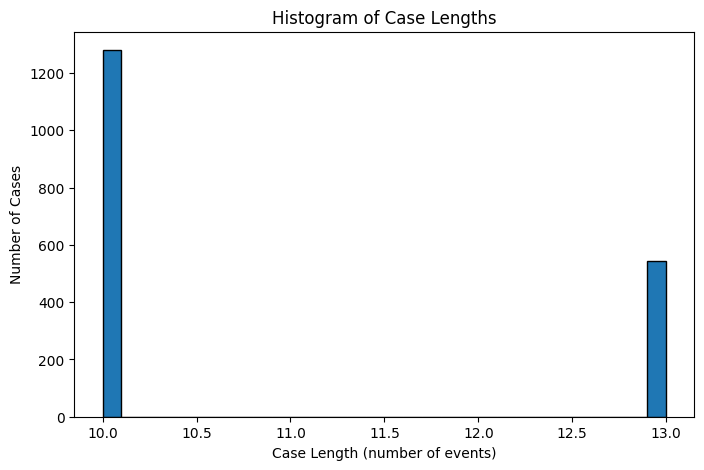

count    1824.000000
mean       10.894737
std         1.372840
min        10.000000
25%        10.000000
50%        10.000000
75%        13.000000
max        13.000000
dtype: float64


In [8]:
## -- Case lengths --

# Compute case lengths (number of events per case)
case_lengths = df.groupby("case:concept:name").size()

# Plot histogram of case lengths
plt.figure(figsize=(8, 5))
plt.hist(case_lengths, bins=30, edgecolor="black")
plt.title("Histogram of Case Lengths")
plt.xlabel("Case Length (number of events)")
plt.ylabel("Number of Cases")
plt.show()

print(case_lengths.describe())

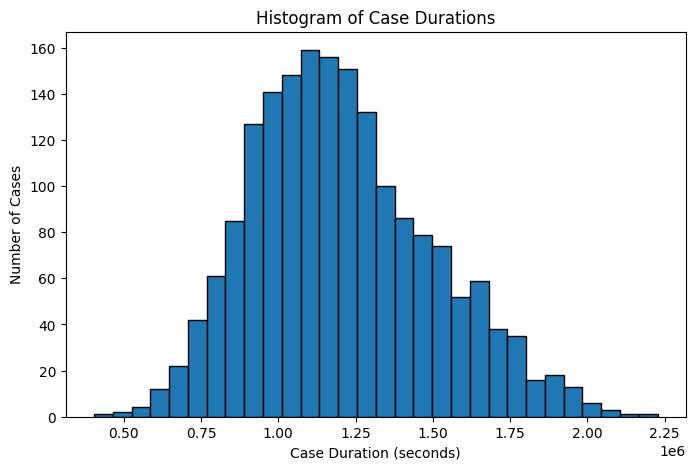

Mean case duration (hh:mm:ss): 13 days, 23:30:33.282895
Median case duration (hh:mm:ss): 13 days, 14:38:09
Min case duration (hh:mm:ss): 4 days, 16:07:21
Max case duration (hh:mm:ss): 25 days, 18:37:00
Std. case duration (hh:mm:ss): 3 days, 9:03:55.491960


In [9]:
# -- Case durations --

from datetime import timedelta

# Compute mean case duration (in seconds)
case_durations = (
    df_trimmed.groupby("case:concept:name")["time:timestamp"]
      .agg(["min", "max"])
      .assign(duration=lambda x: (x["max"] - x["min"]).dt.total_seconds())
)

# Plot histogram
plt.figure(figsize=(8, 5))
plt.hist(case_durations["duration"], bins=30, edgecolor="black")
plt.title("Histogram of Case Durations")
plt.xlabel("Case Duration (seconds)")
plt.ylabel("Number of Cases")
plt.show()

#print(case_durations.describe())
print("Mean case duration (hh:mm:ss):", timedelta(seconds=case_durations["duration"].mean()))
print("Median case duration (hh:mm:ss):", timedelta(seconds=case_durations["duration"].median()))
print("Min case duration (hh:mm:ss):", timedelta(seconds=case_durations["duration"].min()))
print("Max case duration (hh:mm:ss):", timedelta(seconds=case_durations["duration"].max()))
print("Std. case duration (hh:mm:ss):", timedelta(seconds=case_durations["duration"].std()))

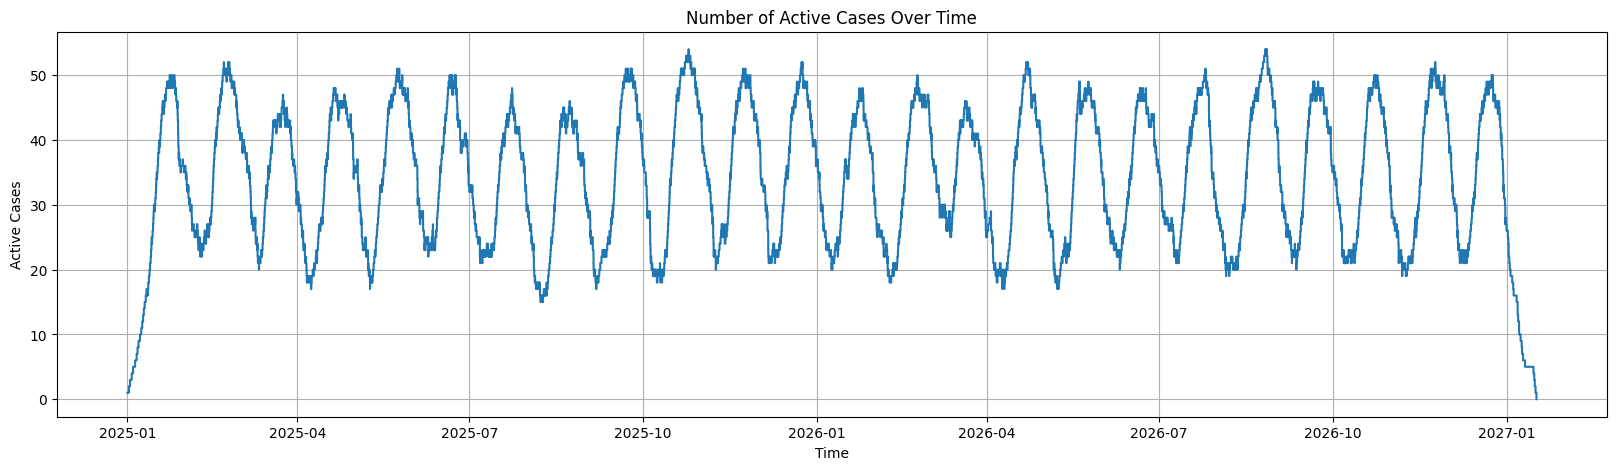

In [10]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt


# Compute start and end per case
case_times = (
    df.groupby("case:concept:name")["time:timestamp"]
      .agg(["min", "max"])
      .rename(columns={"min": "start", "max": "end"})
)

# Build event timeline (+1 at start, -1 at end)
timeline = pd.concat([
    pd.DataFrame({"time": case_times["start"], "change": 1}),
    pd.DataFrame({"time": case_times["end"], "change": -1})
]).sort_values("time")

# Compute number of active cases
timeline["active_cases"] = timeline["change"].cumsum()

# Plot line chart
plt.figure(figsize=(20, 5))
plt.plot(timeline["time"], timeline["active_cases"], drawstyle="steps-post")
plt.title("Number of Active Cases Over Time")
plt.xlabel("Time")
plt.ylabel("Active Cases")
plt.grid(True)
plt.show()


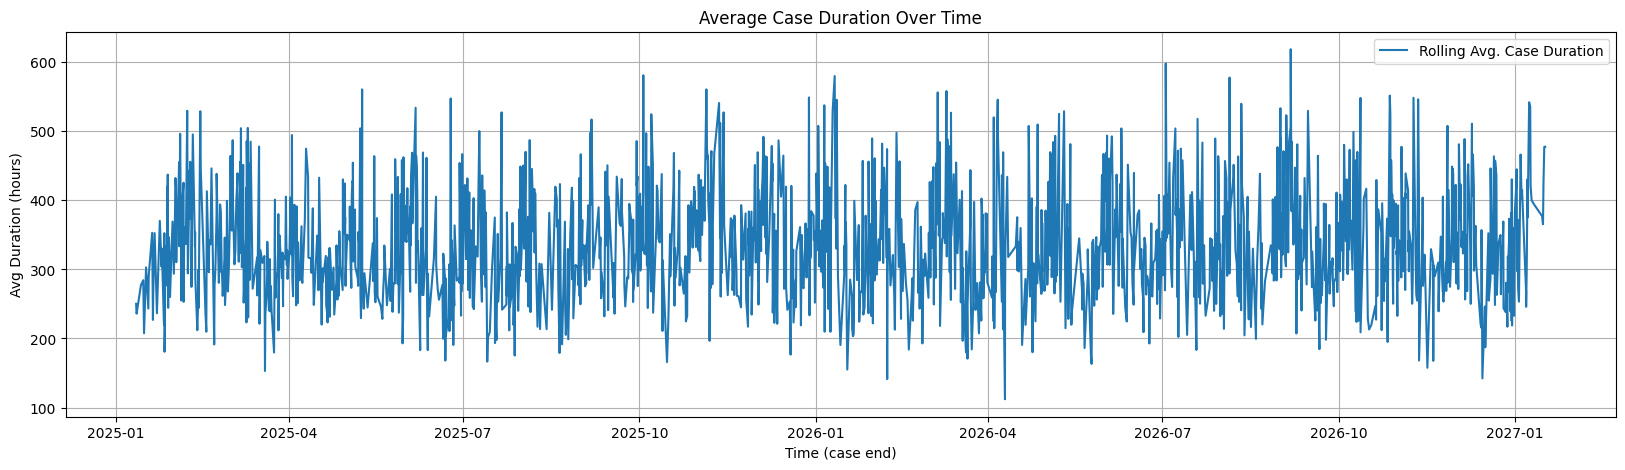

In [11]:
import pm4py
import pandas as pd
import matplotlib.pyplot as plt

# Load log as DataFrame
#df = pm4py.read_xes("event_log.xes", return_dataframe=True)

# Compute start and end per case
case_times = (
    df.groupby("case:concept:name")["time:timestamp"]
      .agg(["min", "max"])
      .rename(columns={"min": "start", "max": "end"})
)
case_times["duration"] = (case_times["end"] - case_times["start"]).dt.total_seconds()

# Sort by end time
case_times = case_times.sort_values("end")

# Rolling 24h average based on case end times
case_times = case_times.set_index("end")
rolling_avg = (
    case_times["duration"]
    .rolling("1h")       # time-based rolling window of 1 hour
    .mean()
    / 3600                # convert to hours
)

# Plot
plt.figure(figsize=(20, 5))
plt.plot(rolling_avg.index, rolling_avg, label="Rolling Avg. Case Duration")
plt.title("Average Case Duration Over Time")
plt.xlabel("Time (case end)")
plt.ylabel("Avg Duration (hours)")
plt.grid(True)
plt.legend()
plt.show()


Top 5 dominant frequencies (Hz = cycles/second): [0.00000000e+00 1.51103052e-06 2.89614184e-06 1.25919210e-07
 1.88878815e-07]
Corresponding periods:
 - inf hours (~inf days)
 - 183.83 hours (~7.66 days)
 - 95.91 hours (~4.00 days)
 - 2206.00 hours (~91.92 days)
 - 1470.67 hours (~61.28 days)


/tmp/ipykernel_3311190/3098883560.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  ts = ts.resample("1H").mean().interpolate()
/tmp/ipykernel_3311190/3098883560.py:27: RuntimeWarning: divide by zero encountered in divide
  dominant_periods = 1 / dominant_freqs  # in seconds


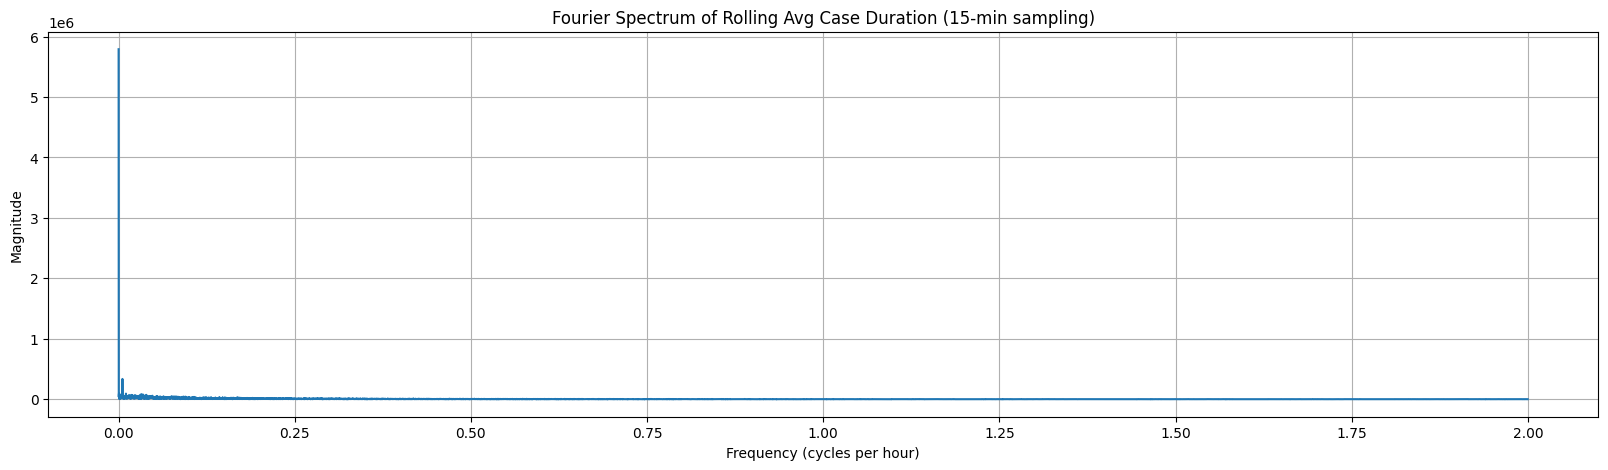

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `rolling_avg` is your pandas Series with datetime index (from earlier code)

# Drop NaN values
ts = rolling_avg.dropna()

# Resample to 15-minute intervals (uniform sampling for FFT)
ts = ts.resample("1H").mean().interpolate()

# Convert to numpy array
y = ts.values
n = len(y)

# Apply FFT
fft_vals = np.fft.fft(y)
fft_freqs = np.fft.fftfreq(n, d=15*60)  # d=15 minutes = 900 seconds

# Keep only positive frequencies
positive_freqs = fft_freqs[:n//2]
magnitudes = np.abs(fft_vals[:n//2])

# Find top 5 dominant frequencies
dominant_indices = magnitudes.argsort()[-5:][::-1]
dominant_freqs = positive_freqs[dominant_indices]
dominant_periods = 1 / dominant_freqs  # in seconds

# Convert periods to more readable units
dominant_periods_hours = dominant_periods / 3600
dominant_periods_days = dominant_periods_hours / 24

print("Top 5 dominant frequencies (Hz = cycles/second):", dominant_freqs)
print("Corresponding periods:")
for f, h, d in zip(dominant_freqs, dominant_periods_hours, dominant_periods_days):
    print(f" - {h:.2f} hours (~{d:.2f} days)")

# Plot spectrum
plt.figure(figsize=(20, 5))
plt.plot(positive_freqs*3600, magnitudes)  # convert to cycles per hour
plt.title("Fourier Spectrum of Rolling Avg Case Duration (15-min sampling)")
plt.xlabel("Frequency (cycles per hour)")
plt.ylabel("Magnitude")
plt.grid(True)
plt.show()
